# Neural Graph Fingerprints

## Atom Features and Bond Connections (edge indices)
- Atomic number (which determines atom type as well)
- The number of hydrogen attached to the atom

In [1]:
from torch_geometric.loader import DataLoader
import torch_geometric
import torch


def get_atom_features(mol):
    atomic_number = []
    num_hs = []

    for atom in mol.GetAtoms():
        atomic_number.append(atom.GetAtomicNum())
        num_hs.append(atom.GetTotalNumHs(includeNeighbors=True))

    return torch.tensor([atomic_number, num_hs], dtype=torch.float).t()  # 获得一个[n_atom,2]的矩阵，n_atom为分子中原子的个数


def get_edge_index(mol):
    row, col = [], []

    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        row += [start, end]
        col += [end, start]
    return torch.tensor([row, col], dtype=torch.long)  # 获得一个[2,2*n_bond]的矩阵，n_bond为分子中化学键的个数


def prepare_dataloader(mol_list, batch_size=3):
    data_list = []

    for i, mol in enumerate(mol_list):
        x = get_atom_features(mol)
        edge_index = get_edge_index(mol)

        data = torch_geometric.data.data.Data(x=x, edge_index=edge_index)
        data_list.append(data)

    return DataLoader(data_list, batch_size=batch_size, shuffle=False), data_list

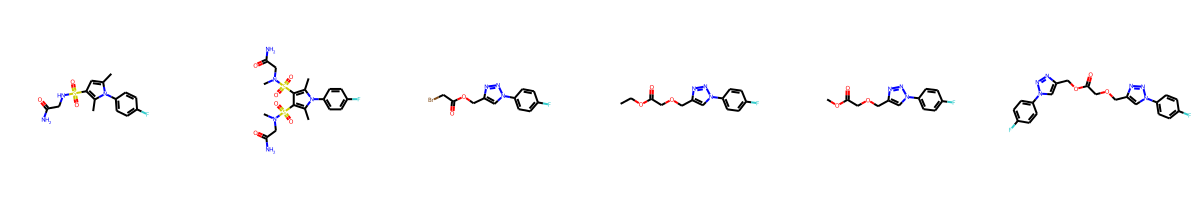

In [2]:
from rdkit.Chem.Draw import MolsToGridImage
from rdkit import Chem

smiles_list = ['Cc1cc(c(C)n1c2ccc(F)cc2)S(=O)(=O)NCC(=O)N',
               'CN(CC(=O)N)S(=O)(=O)c1c(C)n(c(C)c1S(=O)(=O)N(C)CC(=O)N)c2ccc(F)cc2',
               'Fc1ccc(cc1)n2cc(COC(=O)CBr)nn2',
               'CCOC(=O)COCc1cn(nn1)c2ccc(F)cc2',
               'COC(=O)COCc1cn(nn1)c2ccc(F)cc2',
               'Fc1ccc(cc1)n2cc(COCC(=O)OCc3cn(nn3)c4ccc(F)cc4)nn2']

mol_list = [Chem.MolFromSmiles(smi) for smi in smiles_list]
MolsToGridImage(mol_list, molsPerRow=6)

In [3]:
dloader, dlist = prepare_dataloader(mol_list)
print(dlist)
for batch in dloader:
    break
print(batch)

[Data(x=[22, 2], edge_index=[2, 46]), Data(x=[32, 2], edge_index=[2, 66]), Data(x=[18, 2], edge_index=[2, 38]), Data(x=[20, 2], edge_index=[2, 42]), Data(x=[19, 2], edge_index=[2, 40]), Data(x=[31, 2], edge_index=[2, 68])]
DataBatch(x=[72, 2], edge_index=[2, 150], batch=[72], ptr=[4])


## Define the Model

In [4]:
from torch import nn
from torch_geometric.nn import MessagePassing
from torch_scatter import scatter_add
from torch_geometric.utils import add_self_loops


class NeuralLoop(MessagePassing):
    def __init__(self, atom_features, fp_size):
        super(NeuralLoop, self).__init__(aggr='add')
        self.H = nn.Linear(atom_features, atom_features)
        self.W = nn.Linear(atom_features, fp_size)

    def forward(self, x, edge_index):
        # x shape: [Number of atoms in molecule, Number of atom features]; [N, in_channels]
        # edge_index shape: [2, E]; E is twice the number of edges

        # Step 1: 在邻接矩阵中加入自循环的边
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: 消息传递
        # propagate() 消息传递的初始调用，在此方法中 message、update 等方法被调用
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j, edge_index, size):
        # 接收传递给 propagate() 方法的所有参数
        # x_j shape: [E, out_channels]
        # We simply sum all the neighbouring nodes (including self-loops)
        # This is done implicitly by PyTorch-Geometric :)
        return x_j

    def update(self, v):
        # 更新每个节点的节点表征。此方法以 aggregate() 方法的输出为第一个参数，并接收所有传递给 propagate() 方法的参数。
        updated_atom_features = self.H(v).sigmoid()
        updated_fingerprint = self.W(updated_atom_features).softmax(dim=-1)

        return updated_atom_features, updated_fingerprint  # shape [N, atom_features]


class NeuralFP(nn.Module):
    def __init__(self, atom_features=52, fp_size=2048):
        super(NeuralFP, self).__init__()

        self.atom_features = 52
        self.fp_size = 2048

        self.loop1 = NeuralLoop(atom_features=atom_features, fp_size=fp_size)
        self.loop2 = NeuralLoop(atom_features=atom_features, fp_size=fp_size)
        self.loops = nn.ModuleList([self.loop1, self.loop2])

    def forward(self, data):
        fingerprint = torch.zeros((data.batch.shape[0], self.fp_size), dtype=torch.float)

        out = data.x
        for idx, loop in enumerate(self.loops):
            updated_atom_features, updated_fingerprint = loop(out, data.edge_index)
            out = updated_atom_features
            fingerprint += updated_fingerprint

        return scatter_add(fingerprint, data.batch, dim=0)

In [5]:
neural_fp = NeuralFP(atom_features=2, fp_size=2048)
fps = neural_fp(batch)  # remember, batch size was 3
print(fps.shape)

torch.Size([3, 2048])


# Learning fingerprints through backpropagation
To avoid overfit noise in small dataset, Let's try our neural fingerprint on a real dataset.
We will use the BACE regression dataset from DeepChem.

In [6]:
import deepchem as dc

task, (train, valid, test), transformer = dc.molnet.load_bace_regression(featurizer='Raw')
print(task)
train.X, train.y

['pIC50']


(array([<rdkit.Chem.rdchem.Mol object at 0x2867a6450>,
        <rdkit.Chem.rdchem.Mol object at 0x2867a64a0>, ...,
        <rdkit.Chem.rdchem.Mol object at 0x2870b6630>], dtype=object),
 array([[ 1.0652487 ],
        [ 1.17387646],
        [ 1.17387646],
        ...,
        [-0.14795301],
        [-0.1425272 ],
        [-0.13139333]]))

In [7]:
bs = 32

train_loader, _ = prepare_dataloader(list(train.X), bs)
valid_loader, _ = prepare_dataloader(list(valid.X), bs)
test_loader, _ = prepare_dataloader(list(test.X), bs)

train_labels_loader = torch.utils.data.DataLoader(train.y, batch_size=bs)
valid_labels_loader = torch.utils.data.DataLoader(valid.y, batch_size=bs)
test_labels_loader = torch.utils.data.DataLoader(test.y, batch_size=bs)

Now we build a small MLP on top of our neural fingerprint. We give it just 1 hidden layer (of dimension 100)

In [8]:
import torch.nn.functional as F


class MLP_Regressor(nn.Module):
    def __init__(self, atom_features=2, fp_size=2048, hidden_size=100):
        super(MLP_Regressor, self).__init__()
        self.neural_fp = neural_fp
        self.lin1 = nn.Linear(fp_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, batch):
        fp = self.neural_fp(batch)
        hidden = F.relu(self.dropout(self.lin1(fp)))
        out = self.lin2(hidden)
        return out

Define our utility functions for training and validation

In [9]:
def train_step(batch, labels, reg):
    out = reg(batch)
    loss = F.mse_loss(out, labels.to(torch.float), reduction='mean')
    loss.backward()
    return loss


def valid_step(batch, labels, reg):
    out = reg(batch)
    loss = F.mse_loss(out, labels.to(torch.float), reduction='mean')
    return loss


def train_fn(train_loader, train_labels_loader, reg, opt):
    reg.train()
    total_loss = 0
    for idx, (batch, labels) in enumerate(zip(train_loader, train_labels_loader)):
        loss = train_step(batch, labels, reg)
        total_loss += loss.item()

    torch.nn.utils.clip_grad_norm_(reg.parameters(), 1)
    opt.step()
    opt.zero_grad()
    return total_loss / len(train_loader)


def valid_fn(valid_loader, valid_labels_loader, reg):
    reg.eval()
    total_loss = 0
    with torch.no_grad():
        for idx, (batch, labels) in enumerate(zip(valid_loader, valid_labels_loader)):
            loss = valid_step(batch, labels, reg)
            total_loss += loss.item()

    total_loss /= len(valid_loader)

    return total_loss

And Finally, our optimizer, and the training loop

In [10]:
reg = MLP_Regressor(atom_features=2, fp_size=2048, hidden_size=100)
optimizer = torch.optim.SGD(reg.parameters(), lr=0.01, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100)

total_epochs = 100
for epoch in range(1, total_epochs + 1):
    train_loss = train_fn(train_loader, train_labels_loader, reg, opt=optimizer)
    valid_loss = valid_fn(valid_loader, valid_labels_loader, reg)
    scheduler.step(valid_loss)

    if epoch % 10 == 0:
        print(f'Epoch:{epoch}, Train loss: {train_loss}, Valid loss: {valid_loss}')

Epoch:10, Train loss: 0.9912267392011065, Valid loss: 0.3706662374548614
Epoch:20, Train loss: 0.980072200886513, Valid loss: 0.3752727651968598
Epoch:30, Train loss: 0.970222790970614, Valid loss: 0.36951844533905387
Epoch:40, Train loss: 0.9616958073487407, Valid loss: 0.36430913005024196
Epoch:50, Train loss: 0.9522084214381481, Valid loss: 0.3582670859992504
Epoch:60, Train loss: 0.9397618477477839, Valid loss: 0.351974780857563
Epoch:70, Train loss: 0.9280946191008154, Valid loss: 0.34917973894625903
Epoch:80, Train loss: 0.9134288934108458, Valid loss: 0.342571465857327
Epoch:90, Train loss: 0.90236122112133, Valid loss: 0.3398273766040802
Epoch:100, Train loss: 0.8932751572053683, Valid loss: 0.3401618044823408
